In [34]:
#What are the statistical properties of a network of geographical districts?
#Take distances and population as the key variables.
#Example with data of Argentina.

%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import networkx as nx


with open('localidadesArg.json') as f:
    data = json.load(f)

#Get data
coords = [] #coordinates
pop = [] #population
nombres = [] #names

for feature in data['features']:
#     print feature['geometry']['type']
    coords.append(feature['geometry']['coordinates'])
n = len(coords)

#Transpose
coordstr = map(list, zip(*coords))
    
for feature in data['features']:
    pop.append(feature['properties']['personas'])
    
for feature in data['features']:
    nombres.append(feature['properties']['nombre'])
    

In [35]:
# plt.scatter(coords[:, 0],coords[:, 1])
x = [c[0] for c in coords]
y = [c[1] for c in coords]

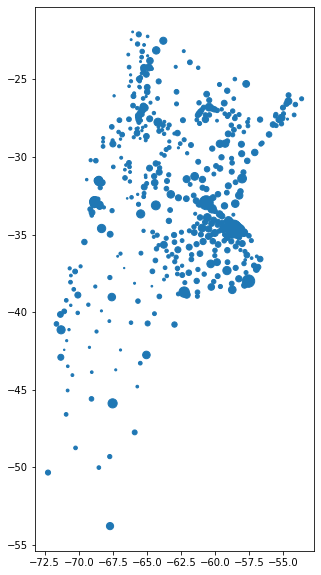

In [16]:
plt.figure(figsize=(5,10))

x = [c[0] for c in coords]
y = [c[1] for c in coords]
# plt.scatter(coordstr[0],coordstr[1], s = np.sqrt(pop)/5.)
plt.scatter(x, y, s = np.sqrt(pop)/5.)

plt.show()

In [17]:
#Calculate distances between all pairs of points out of geodesic coords. This is key for gravity type equations
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [18]:
# distances = [[haversine(j[0],j[1],i[0],i[1]) for j in coords] for i in coords]

In [ ]:
# pd.DataFrame(gravity, columns)

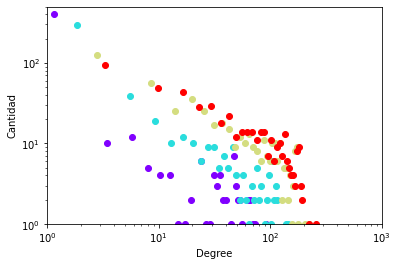

In [38]:
#Choose typical distance (in km) and apply a fat-tail rule: e^(-sqrt(x)).
# This function behaves like 1/x^2 for x around 1, hence it goes like a gravity equation. 
# The difference is it doesn't diverge when x=0 and hence it is more of a probability distribution.
# It has been argued human mobility patterns follow this fat tail distributions (Levy flight).

# d=np.median(distancesFlat)
#Play with this parameter, it's the TYPICAL DISTANCE in km.
d=100
gravity = [[pop[i]*pop[j]*np.exp(1-(distances[i][j]/d)) if i != j else 0 for j in range(n)] for i in range(n)]

#Flatten gravity array, so to take percentiles, so to binarize with different levels.
gravityFlat = [val for sublist in gravity for val in sublist]
#Here choose percentiles (0:100) small values make the adjacency matrix sparse
percentiles = [np.percentile(gravityFlat, 100 - l) for l in [1, 3, 9, 11]]  #Play with percentile levels
gravitybin = [[[1 if gravity[i][j] > p else 0 for j in range(n)] for i in range(n)] for p in percentiles]

#Get degrees summing over rows of binary adjacency matrix.
degrees = [[sum(i) for i in percMat] for percMat in gravitybin]

#Plot colors and options
#Plot for various binarizing percentiles.
colors = cm.rainbow(np.linspace(0, 1, 4))
for i, c in zip(range(4), colors):
    counts,bin_edges = np.histogram(degrees[i],40)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    plt.scatter(bin_centres, counts, color=c)
plt.yscale("log")
plt.xscale("log")
axes = plt.gca()
axes.set_xlim([1,1000])
axes.set_ylim([1,500])

plt.xlabel('Degree')
plt.ylabel('Cantidad')

plt.show()

#Scale free - Small world is observed.
#Many towns have low degree, few big districts connect to many cities of intermediate size.
#This result holds for sparse adjacency matrix (otherwise most nodes connect to most nodes)

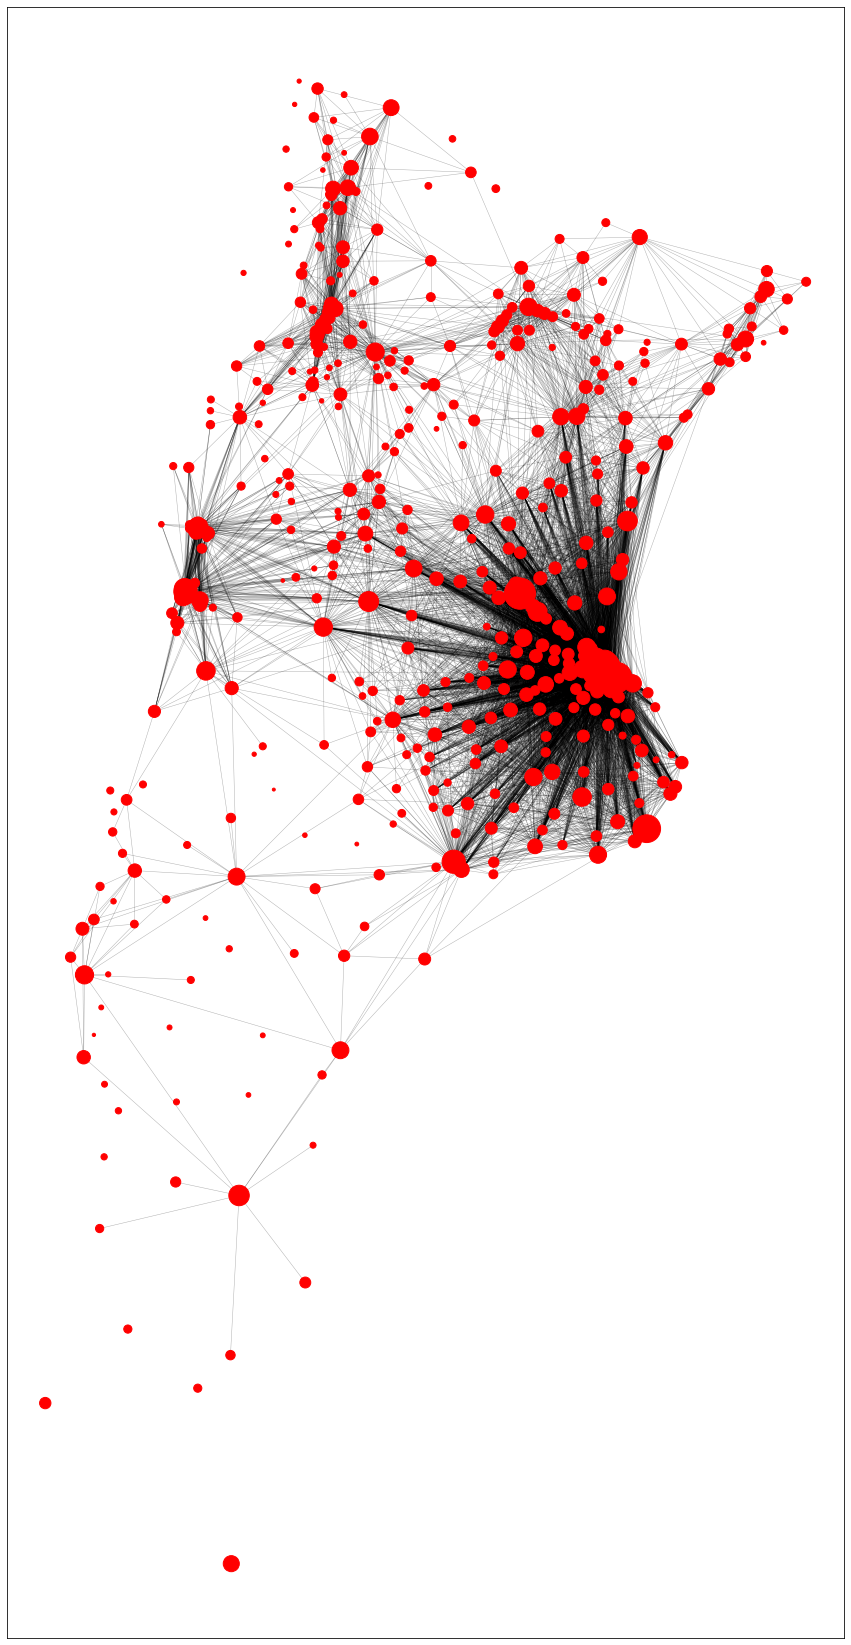

In [25]:
#But how does it look on the geographical layer?

#Function to draw graphs
def draw_graph(graph):
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    pos = {i: (coords[i][0], coords[i][1]) for i in range(n)}
    # draw nodes, edges and labels
    nx.draw_networkx_nodes(G,pos,node_size=np.sqrt(pop),nodelist=range(n),node_color='r')
    nx.draw_networkx_edges(G, pos, width = .5, alpha = .3)
#     nx.draw_networkx_labels(G, graph_pos, font_size=12, font_family='sans-serif')

    # show graph
    plt.show()

#It can be seen how towns may connect to nearby towns, and to regional center, 
# which due to higher population is able to connect to farther regional center. 
# The districts in Buenos Aires show very high connectivity.
graph = [(i[0],i[1]) for i in np.argwhere(gravitybin[2])]
plt.figure(figsize=(15,30))
draw_graph(graph)
X=nx.Graph()

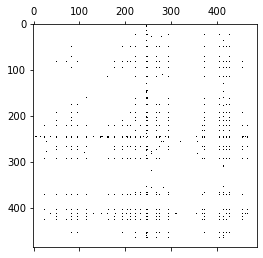

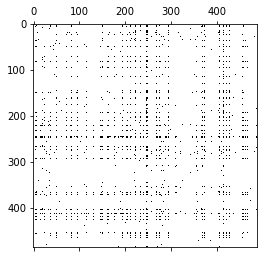

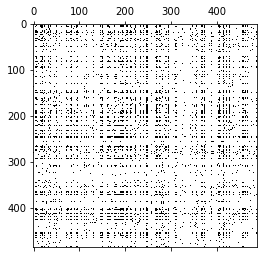

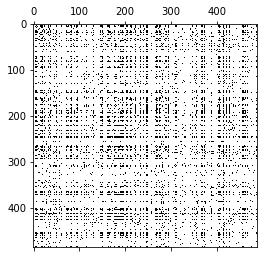

In [26]:
#Check the adjacency matrix for the chosen percentiles
for i in range(4):
    plt.matshow(gravitybin[i], fignum=100, cmap=plt.cm.Greys)
    plt.show()

In [ ]:
#To see degrees by district name...
# for i in range(len(degrees[1])): 
#     print degrees[1][i], nombres[i]